In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Conv2D, GlobalAveragePooling2D,GlobalMaxPooling2D
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_dir = "/content/drive/MyDrive/segmented/Train_mask"
validation_dir = "/content/drive/MyDrive/segmented/Val_mask"
test_dir= "/content/drive/MyDrive/segmented/Test_mask"


In [4]:
img_size = (256, 256)
batch_size = 32

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)


In [6]:
# Create generators for training and validation sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
)
validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 1058 images belonging to 2 classes.
Found 381 images belonging to 2 classes.


In [7]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Corona Virus
1 : Normal


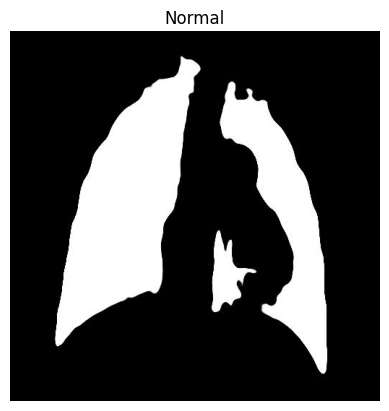

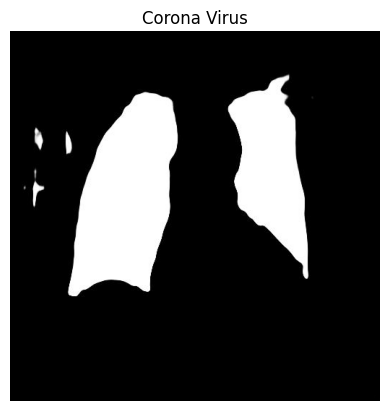

In [8]:
import os
import random
import matplotlib.pyplot as plt
def plot_sample_images(directory, label):
    class_labels = ['Normal', 'Corona Virus']
    class_dir = os.path.join(directory, class_labels[label])
    image_files = os.listdir(class_dir)
    random_image = random.choice(image_files)
    img_path = os.path.join(class_dir, random_image)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(class_labels[label])
    plt.axis('off')
    plt.show()

plot_sample_images(test_dir, 0) # Normal
plot_sample_images(test_dir, 1) # COVID

In [9]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(256,256,3))

for layer in base_model.layers:
    layer.trainable = False

80134624/80134624 [==============================] - 0s 0us/step


In [10]:
from tensorflow.keras.optimizers import Adam
x=base_model.get_layer(index=-1).output
x=Flatten()(x)
x=Dense(256,activation='relu')(x)
x=BatchNormalization()(x)
x=Dropout(0.2)(x)
x=Dense(1,activation='sigmoid')(x)

model=Model(base_model.input,x)

model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [11]:
history=model.fit(train_generator,epochs=5,validation_data=validation_generator)

Epoch 1/5
34/34 [==============================] - 220s 6s/step - loss: 0.1255 - accuracy: 0.9575 - val_loss: 0.2350 - val_accuracy: 0.9291
Epoch 2/5
34/34 [==============================] - 30s 878ms/step - loss: 0.0580 - accuracy: 0.9811 - val_loss: 0.0980 - val_accuracy: 0.9659
Epoch 3/5
34/34 [==============================] - 30s 894ms/step - loss: 0.0453 - accuracy: 0.9849 - val_loss: 0.0507 - val_accuracy: 0.9816
Epoch 4/5
34/34 [==============================] - 30s 876ms/step - loss: 0.0416 - accuracy: 0.9868 - val_loss: 0.0526 - val_accuracy: 0.9764
Epoch 5/5
34/34 [==============================] - 30s 880ms/step - loss: 0.0422 - accuracy: 0.9887 - val_loss: 0.0409 - val_accuracy: 0.9816


In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)
data_path_test=test_dir
test_generator = test_datagen.flow_from_directory(
    data_path_test,
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary'
)

# Evaluate the model on the test set
results = model.evaluate(test_generator)

print("Test Loss:",results[0])
print("Test Accuracy:",results[1])

Found 260 images belonging to 2 classes.
9/9 [==============================] - 30s 4s/step - loss: 0.0909 - accuracy: 0.9731
Test Loss: 0.09089529514312744
Test Accuracy: 0.9730769395828247


In [13]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
predictions = model.predict(test_generator)
predictions=(predictions>0.5).astype(int)
y_true = test_generator.classes
print(classification_report(y_true,predictions))

9/9 [==============================] - 2s 232ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       130
           1       0.98      0.97      0.97       130

    accuracy                           0.97       260
   macro avg       0.97      0.97      0.97       260
weighted avg       0.97      0.97      0.97       260



9/9 [==============================] - 2s 176ms/step


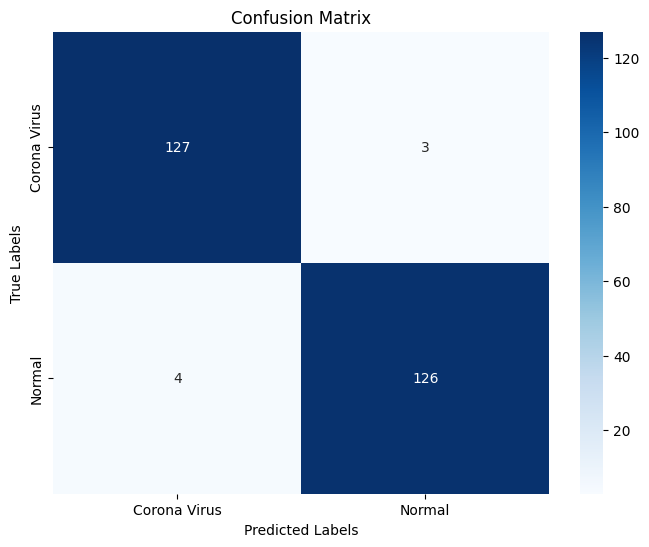

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get the true labels
true_labels = test_generator.classes

# Predict the labels using the model
predictions = model.predict(test_generator)

predictions=(predictions>0.5).astype(int)
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels,predictions)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()